In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

2025-03-27 09:27:07.722332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# G20 countries with ISO codes
G20_COUNTRIES = {
    "Argentina": "ARG", 
    "Australia": "AUS", 
    "Brazil": "BRA", 
    "Canada": "CAN", 
    "China": "CHN", 
    "France": "FRA", 
    "Germany": "DEU", 
    "India": "IND", 
    "Indonesia": "IDN", 
    "Italy": "ITA", 
    "Japan": "JPN", 
    "Mexico": "MEX", 
    "Russia": "RUS", 
    "Saudi Arabia": "SAU", 
    "South Africa": "ZAF", 
    "Korea, Rep.": "KOR", 
    "Turkey": "TUR", 
    "United Kingdom": "GBR", 
    "United States": "USA"
}

# Alternative names that might appear in the dataset
G20_ALTERNATIVE_NAMES = {
    "Korea, Rep.": ["South Korea", "Republic of Korea"],
    "Russia": ["Russian Federation"],
    "United Kingdom": ["UK", "Great Britain"],
    "United States": ["USA", "US"]
}

# Reverse mapping from ISO to standard name for visualization
ISO_TO_NAME = {iso: name for name, iso in G20_COUNTRIES.items()}

# Primary data loading function - reads the JSON file containing merged SIPRI and World Bank data
def load_data(filepath):
    """Load the merged dataset from JSON file"""
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

# Extracts only G20 countries from the full dataset for focused analysis
def extract_g20_countries(data):
    """Extract G20 countries from the dataset using ISO codes"""
    g20_data = []
    
    # Create a lookup set of G20 ISO codes
    g20_iso_set = set(G20_COUNTRIES.values())
    
    # Create a lookup set with all possible G20 country names
    g20_names_set = set(G20_COUNTRIES.keys())
    for country, alternatives in G20_ALTERNATIVE_NAMES.items():
        g20_names_set.update(alternatives)
    
    for country in data.get('countries', []):
        # First try matching by ISO code (more reliable)
        if country['ISO'] in g20_iso_set:
            country_copy = country.copy()
            # Store the standard name based on ISO
            country_copy['std_name'] = ISO_TO_NAME.get(country['ISO'], country['name'])
            g20_data.append(country_copy)
        # If ISO doesn't match, try matching by name as fallback
        elif country['name'] in g20_names_set:
            # Map alternative names to standard G20 name
            std_name = country['name']
            for g20_name, alternatives in G20_ALTERNATIVE_NAMES.items():
                if country['name'] in alternatives:
                    std_name = g20_name
                    break
            
            country_copy = country.copy()
            country_copy['std_name'] = std_name
            # If we can determine the ISO from the name, use that
            country_copy['std_ISO'] = G20_COUNTRIES.get(std_name, country['ISO'])
            g20_data.append(country_copy)
    
    return g20_data

# Transforms nested country time series data into a flat pandas DataFrame for analysis
def convert_to_dataframe(countries_data):
    """Convert the time series data for countries into a pandas DataFrame"""
    rows = []
    
    for country in countries_data:
        country_name = country.get('std_name', country['name'])
        country_iso = country.get('std_ISO', country['ISO'])
        
        for year_data in country['time_series']:
            row = {'country': country_name, 'ISO': country_iso, 'year': year_data['year']}
            row.update(year_data)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

# filter the df to include a range of years
def filter_years(df, start_year, end_year):
    """Filter the DataFrame to include only the specified range of years"""
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

# test the functions
data = load_data('../../data/all_data_merged_cleaned.json')
g20_data = extract_g20_countries(data)
df = convert_to_dataframe(g20_data)
df = filter_years(df, 1990, 2019)   # filter the data to include only the years 1990-2019

# show the list of indicators as a dataframe and the first 3 coloumns of the head of the dataframe
print(df.columns)
print(df.head(3))


Index(['country', 'ISO', 'year', 'military_expenditure',
       'military_expenditure_gdp', 'arms_exports_sipri_trend_indicator_values',
       'political_stability_and_absence_of_violenceterrorism_percentile_rank',
       'armed_forces_personnel_total',
       'income_share_held_by_highest_10percent',
       'refugee_population_by_country_or_territory_of_origin',
       'rural_population_percent_of_total_population',
       'arms_imports_sipri_trend_indicator_values',
       'income_share_held_by_lowest_10percent',
       'internally_displaced_persons_total_displaced_by_conflict_and_violence_number_of_people',
       'international_migrant_stock_percent_of_population',
       'gdp_growth_annual_percent',
       'foreign_direct_investment_net_outflows_percent_of_gdp',
       'individuals_using_the_internet_percent_of_population',
       'tax_revenue_percent_of_gdp',
       'tariff_rate_applied_simple_mean_all_products_percent',
       'fossil_fuel_energy_consumption_percent_of_total',


Missing values found in the dataset:
arms_exports_sipri_trend_indicator_values                                                 122
political_stability_and_absence_of_violenceterrorism_percentile_rank                      169
income_share_held_by_highest_10percent                                                    245
refugee_population_by_country_or_territory_of_origin                                       43
arms_imports_sipri_trend_indicator_values                                                  27
income_share_held_by_lowest_10percent                                                     245
internally_displaced_persons_total_displaced_by_conflict_and_violence_number_of_people    514
international_migrant_stock_percent_of_population                                         455
foreign_direct_investment_net_outflows_percent_of_gdp                                      10
individuals_using_the_internet_percent_of_population                                        3
tax_revenue_percent_of_

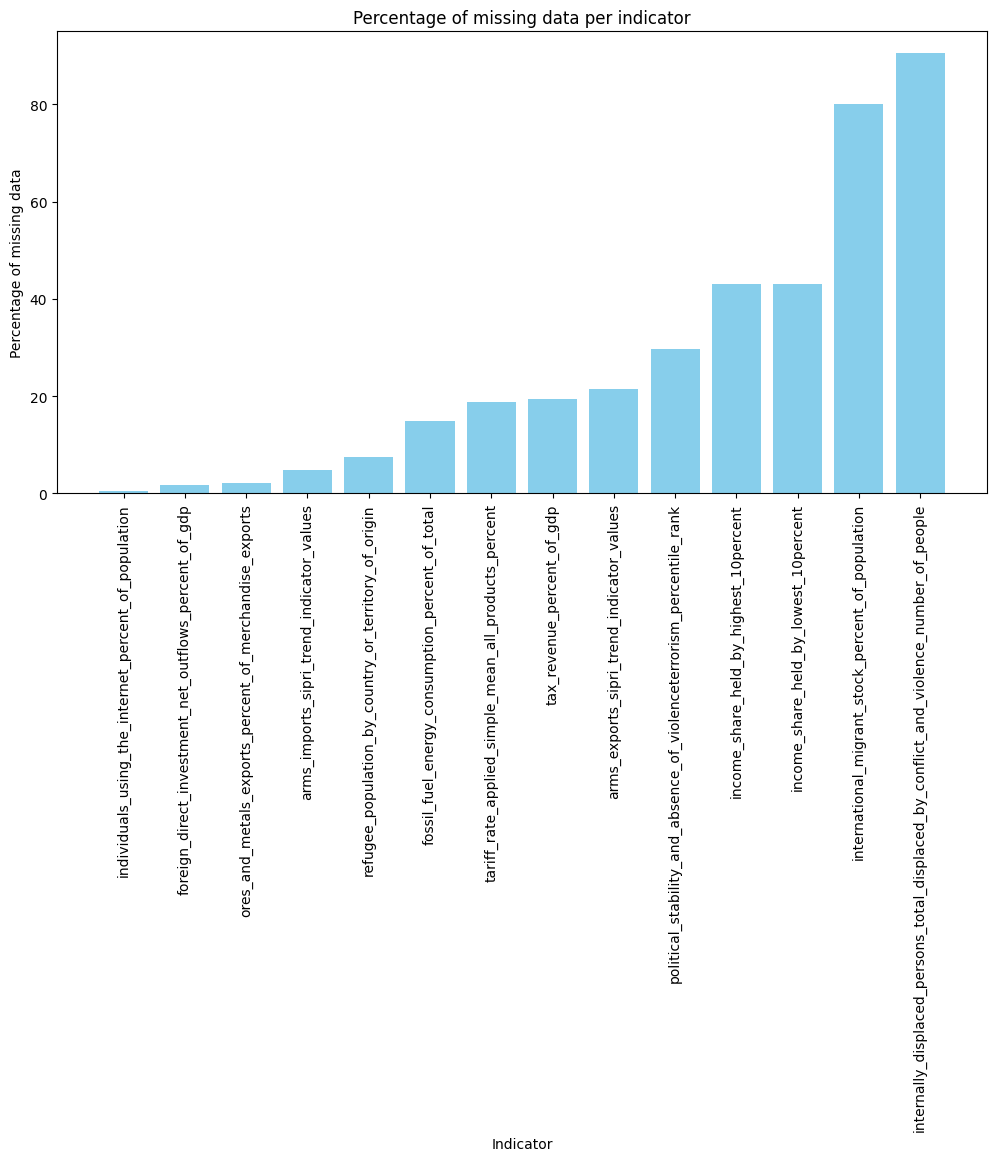

/var/folders/3z/dmm62d916pv2lznj6d0yfh200000gn/T/ipykernel_4519/4224826237.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data_country = df.groupby('country').apply(lambda x: x.isnull().mean()) * 100


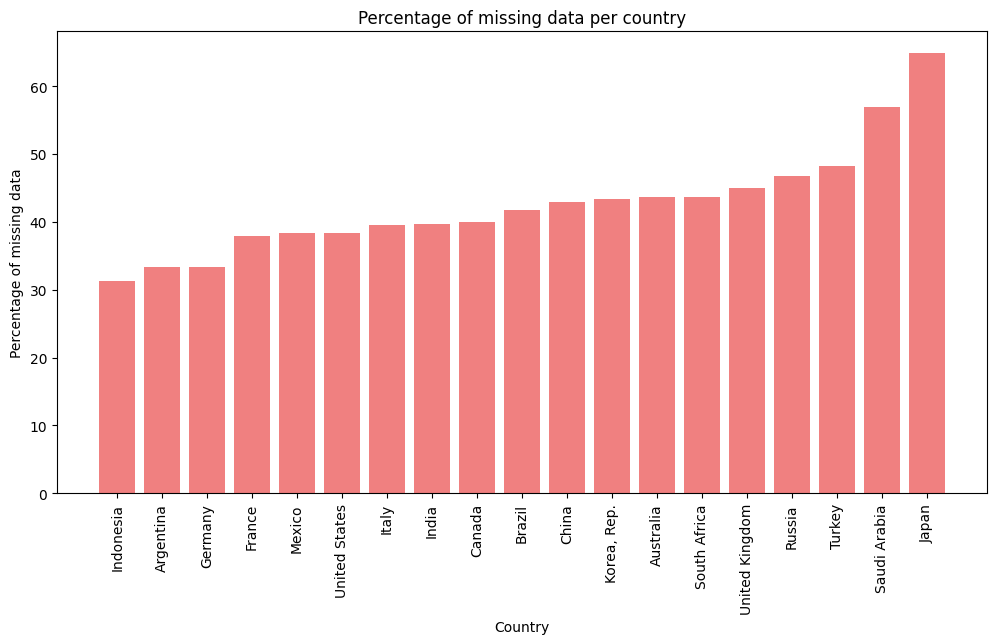

In [3]:
# Function to highlight missing data integrity issues in the dataset
def check_missing_data(df):
    """
    Check for missing data in the DataFrame and highlight potential issues
    
    Parameters:
    df (DataFrame): Input DataFrame
    """
    missing_values = df.isnull().sum()
    
    if missing_values.sum() == 0:
        print("No missing values found in the dataset")
    else:
        print("Missing values found in the dataset:")
        print(missing_values[missing_values > 0])
        
# bar charts to show percentage of missing datapoints per indicator and country
def bar_chart_missing_data(df):
    """
    Create bar charts to show the percentage of missing data per indicator and country
    
    Parameters:
    df (DataFrame): Input DataFrame
    """
    # Calculate the percentage of missing data per indicator
    missing_data = df.isnull().mean() * 100
    missing_data = missing_data[missing_data > 0]
    missing_data.sort_values(inplace=True)
    
    # Create a bar chart for missing data per indicator
    plt.figure(figsize=(12, 6))
    plt.bar(missing_data.index, missing_data.values, color='skyblue')
    plt.title('Percentage of missing data per indicator')
    plt.xlabel('Indicator')
    plt.ylabel('Percentage of missing data')
    plt.xticks(rotation=90)
    plt.show()
    
    # Calculate the percentage of missing data per country
    missing_data_country = df.groupby('country').apply(lambda x: x.isnull().mean()) * 100
    missing_data_country = missing_data_country[missing_data_country > 0].mean(axis=1)
    missing_data_country.sort_values(inplace=True)
    
    # Create a bar chart for missing data per country
    plt.figure(figsize=(12, 6))
    plt.bar(missing_data_country.index, missing_data_country.values, color='lightcoral')
    plt.title('Percentage of missing data per country')
    plt.xlabel('Country')
    plt.ylabel('Percentage of missing data')
    plt.xticks(rotation=90)
    plt.show()

# Check for missing data in the dataset
check_missing_data(df)
bar_chart_missing_data(df)


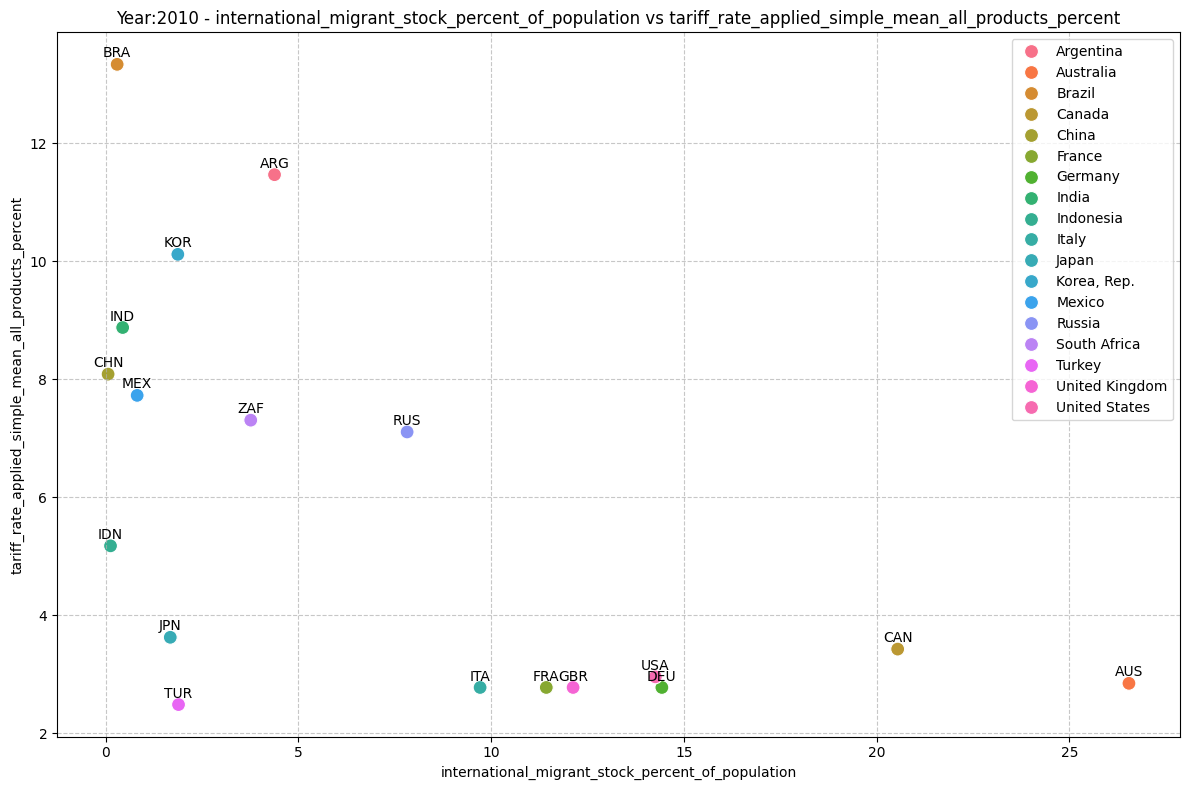

No data found for country: United States 


In [4]:
# Creates a visual comparison between two indicators with country labels
def create_scatter_plot(df, x_indicator, y_indicator, year=None, countries=None, title=None, use_iso=True):
    """
    Create a scatter plot of two indicators for countries
    
    Parameters:
    df (DataFrame): DataFrame with country data
    x_indicator (str): Name of the indicator for x-axis
    y_indicator (str): Name of the indicator for y-axis
    year (int): Optional specific year to visualize
    countries (list): Optional list of specific country ISO codes to include
    title (str): Optional title for the plot
    use_iso (bool): Whether to use ISO codes or country names for identification
    """
    if year is not None:
        df = df[df['year'] == year]
    
    if countries is not None:
        id_column = 'ISO' if use_iso else 'country'
        df = df[df[id_column].isin(countries)]
    
    if x_indicator not in df.columns or y_indicator not in df.columns:
        print(f"Error: Indicators {x_indicator} or {y_indicator} not found in data")
        return
    
    # Drop rows with missing values for the selected indicators
    plot_df = df.dropna(subset=[x_indicator, y_indicator])
    
    if plot_df.empty:
        print("No data available for the selected indicators and filters")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot using ISO for the hue
    scatter_plot = sns.scatterplot(data=plot_df, x=x_indicator, y=y_indicator, 
                                  hue='ISO' if use_iso else 'country', s=100)
    
    # Add labels to points
    for _, row in plot_df.iterrows():
        label = row['ISO'] if use_iso else row['country']
        plt.annotate(label, 
                    (row[x_indicator], row[y_indicator]),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha='center')
    
    plt.xlabel(x_indicator)
    plt.ylabel(y_indicator)
    
    if year:
        title_suffix = f" ({year})"
    else:
        title_suffix = ""
        
    plt.title(title or f"Relationship between {x_indicator} and {y_indicator}{title_suffix}")
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Update legend with country names if needed
    if not use_iso:
        handles, labels = scatter_plot.get_legend_handles_labels()
        plt.legend(handles=handles, labels=labels)
    else:
        handles, labels = scatter_plot.get_legend_handles_labels()
        plt.legend(handles=handles, labels=[ISO_TO_NAME.get(iso, iso) for iso in labels])
    
    plt.show()

# create a scatter plot for two indicators for one country over a few years
def create_country_time_series(df, country, indicator1, indicator2, title=None):
    """
    Create a time series plot of two indicators for a specific country
    
    Parameters:
    df (DataFrame): DataFrame with country data
    country (str): Name of the country to visualize
    indicator1 (str): Name of the first indicator
    indicator2 (str): Name of the second indicator
    title (str): Optional title for the plot
    """
    country_data = df[df['country'] == country]
    
    if country_data.empty:
        print(f"No data found for country: {country}")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create line plots for the two indicators
    plt.plot(country_data['year'], country_data[indicator1], label=indicator1, marker='o')
    plt.plot(country_data['year'], country_data[indicator2], label=indicator2, marker='o')
    
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title(title or f"{indicator1} and {indicator2} over time for {country}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# create a list of potential indicators to use
indicators = df.columns[3:]

indicator1 = 'international_migrant_stock_percent_of_population'
indicator2 = 'tariff_rate_applied_simple_mean_all_products_percent'

# Create a scatter plot of two indicators for countries
create_scatter_plot(df, indicator1, indicator2, year=2010, title = 'Year:{} - {} vs {}'.format(2010, indicator1, indicator2))

# Create a time series plot of two indicators for a specific country
create_country_time_series(df, 'United States ', indicator1, indicator2)



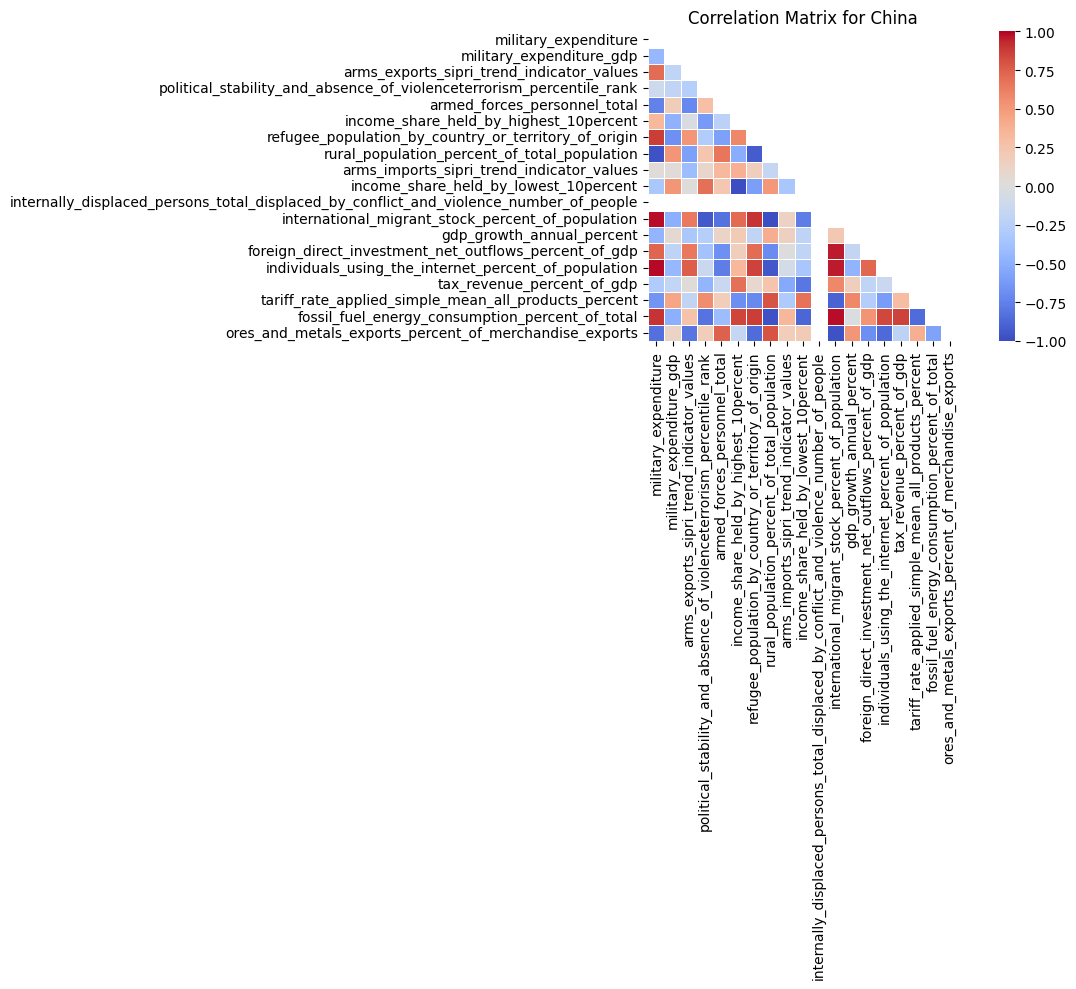

In [7]:
# Calculates Pearson correlation coefficients between indicators for a specific country
def calculate_pearson_correlation(df, country_iso, indicators=None, use_iso=True):
    """
    Calculate Pearson correlation coefficients between indicators for a specific country
    
    Parameters:
    df (DataFrame): DataFrame with country data
    country_iso (str): Country ISO code
    indicators (list): Optional list of specific indicators to include
    use_iso (bool): Whether to use ISO codes or country names for identification
    
    Returns:
    DataFrame: Correlation matrix
    """
    id_column = 'ISO' if use_iso else 'country'
    country_df = df[df[id_column] == country_iso]
    
    if indicators:
        indicators = [ind for ind in indicators if ind in country_df.columns]
    else:
        # Exclude non-numeric columns
        indicators = [col for col in country_df.columns 
                     if col not in ['country', 'ISO', 'year'] 
                     and pd.api.types.is_numeric_dtype(country_df[col])]
    
    # Extract only the indicators we're interested in
    correlation_df = country_df[indicators].copy()
    
    # Drop rows with all NaN values
    correlation_df = correlation_df.dropna(how='all')
    
    if correlation_df.empty:
        country_name = ISO_TO_NAME.get(country_iso, country_iso) if use_iso else country_iso
        print(f"No valid data found for {country_name}")
        return None
    
    # Calculate correlation matrix
    corr_matrix = correlation_df.corr(method='pearson')
    
    return corr_matrix

# Creates a visual heatmap of correlation coefficients for a country
def visualize_correlation_matrix(corr_matrix, country_iso, title=None, use_iso=True):
    """
    Visualize a correlation matrix as a heatmap
    
    Parameters:
    corr_matrix (DataFrame): Correlation matrix
    country_iso (str): Country ISO code
    title (str): Optional custom title
    use_iso (bool): Whether to use ISO codes or country names for identification
    """
    if corr_matrix is None:
        return
    
    plt.figure(figsize=(14, 10))
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                annot=False, fmt=".2f", square=True, linewidths=.5)
    
    country_name = ISO_TO_NAME.get(country_iso, country_iso) if use_iso else country_iso
    plt.title(title or f"Correlation Matrix for {country_name}")
    plt.tight_layout()
    plt.show()

# Calculate Pearson correlation coefficients for a specific country
country = 'CHN'
corr_matrix = calculate_pearson_correlation(df, country)
visualize_correlation_matrix(corr_matrix, country)


In [ ]:
# Helper function to identify top-performing countries for a specific metric
def get_top_countries_by_metric(df, metric, year=None, top_n=4, ascending=False, use_iso=True):
    """
    Get the top N countries based on a specific metric
    
    Parameters:
    df (DataFrame): DataFrame with country data
    metric (str): Metric to sort by
    year (int): Optional specific year to consider
    top_n (int): Number of top countries to return
    ascending (bool): Sort order
    use_iso (bool): Whether to return ISO codes or country names
    
    Returns:
    list: List of top country identifiers (ISO or name)
    """
    if year:
        filtered_df = df[df['year'] == year]
    else:
        # Get the most recent year for each country
        filtered_df = df.sort_values('year', ascending=False).drop_duplicates('ISO')
    
    if metric not in filtered_df.columns:
        print(f"Error: Metric {metric} not found in data")
        return []
    
    # Drop countries with missing values for the metric
    filtered_df = filtered_df.dropna(subset=[metric])
    
    # Sort and get top N
    id_column = 'ISO' if use_iso else 'country'
    top_countries = filtered_df.sort_values(by=metric, ascending=ascending)[id_column].head(top_n).tolist()
    
    return top_countries

# Prepares country data for dimensionality reduction by filtering and cleaning the dataset
def prepare_for_dimensionality_reduction(df, indicators, countries, use_iso, 
                                        impute_missing, min_non_null_ratio=0.7):
    """
    Prepare data for dimensionality reduction by extracting a clean matrix
    
    Parameters:
    df (DataFrame): DataFrame with country data
    indicators (list): List of indicators to include
    countries (list): Optional list of country ISO codes to include
    min_year (int): Optional minimum year to include
    max_year (int): Optional maximum year to include
    use_iso (bool): Whether to use ISO codes or country names for identification
    impute_missing (bool): Whether to impute missing values instead of dropping rows
    min_non_null_ratio (float): Minimum ratio of non-null values needed for an indicator to be kept
    
    Returns:
    tuple: (data_matrix, feature_names, row_labels)
    """
    # Make a copy to avoid modifying the original dataframe
    work_df = df.copy()
    
    # Filter by countries if specified
    if countries:
        id_column = 'ISO' if use_iso else 'country'
        work_df = work_df[work_df[id_column].isin(countries)]
    
    # If no indicators specified, use all numeric columns except metadata
    if not indicators:
        all_possible_indicators = [col for col in work_df.columns 
                    if col not in ['country', 'ISO', 'year', 'row_label'] 
                    and pd.api.types.is_numeric_dtype(work_df[col])]
                    
        # Filter out indicators with too many missing values
        indicators = []
        for col in all_possible_indicators:
            non_null_ratio = work_df[col].notna().mean()
            if non_null_ratio >= min_non_null_ratio:
                indicators.append(col)
                
        if not indicators:
            print(f"Warning: No indicators meet the minimum non-null ratio of {min_non_null_ratio}. Try lowering this threshold.")
            # Fall back to using the least-sparse indicators
            if all_possible_indicators:
                non_null_counts = {col: work_df[col].notna().mean() for col in all_possible_indicators}
                sorted_indicators = sorted(non_null_counts.items(), key=lambda x: x[1], reverse=True)
                indicators = [ind for ind, _ in sorted_indicators[:10]]  # Take top 10
                print(f"Using {len(indicators)} indicators with highest coverage.")
    else:
        # Ensure all specified indicators exist in the dataframe
        indicators = [ind for ind in indicators if ind in work_df.columns]
    
    print(f"Number of indicators selected: {len(indicators)}")
    
    # Create row labels with country identifier and year
    id_column = 'ISO' if use_iso else 'country'
    work_df['row_label'] = work_df[id_column] + " (" + work_df['year'].astype(str) + ")"
    
    # Extract only the indicators we're interested in
    data_df = work_df[indicators].copy()
    
    # Handle missing values
    if impute_missing:
        # Simple imputation (interpolation) with the midpoint between the previous and next valid values
        data_df = data_df.interpolate(limit_direction='both')
        # Fill any remaining missing values with the column mean
        data_df = data_df.fillna(data_df.mean())
        complete_indices = data_df.dropna().index
        print(f"Missing values imputed with column means.")
    else:
        # Drop rows with any missing values
        complete_indices = data_df.dropna().index
        data_df = data_df.loc[complete_indices]
        
    # Get row labels for the final dataset
    row_labels = work_df.loc[complete_indices, 'row_label'].tolist()
    
    print(f"Final dataset has {len(row_labels)} rows with complete data.")
    
    # Convert to numpy array for dimensionality reduction
    if len(data_df) > 0:
        data_matrix = data_df.to_numpy()
    else:
        print("Warning: No complete rows found. Returning empty matrix.")
        data_matrix = np.zeros((0, len(indicators)))
    
    return data_matrix, indicators, row_labels

# test function
data_matrix, indicators, row_labels = prepare_for_dimensionality_reduction(df, indicators=None, countries=None, use_iso=True, impute_missing=True)



Number of indicators selected: 15
Missing values imputed with column means.
Final dataset has 298 rows with complete data.


(298, 2)


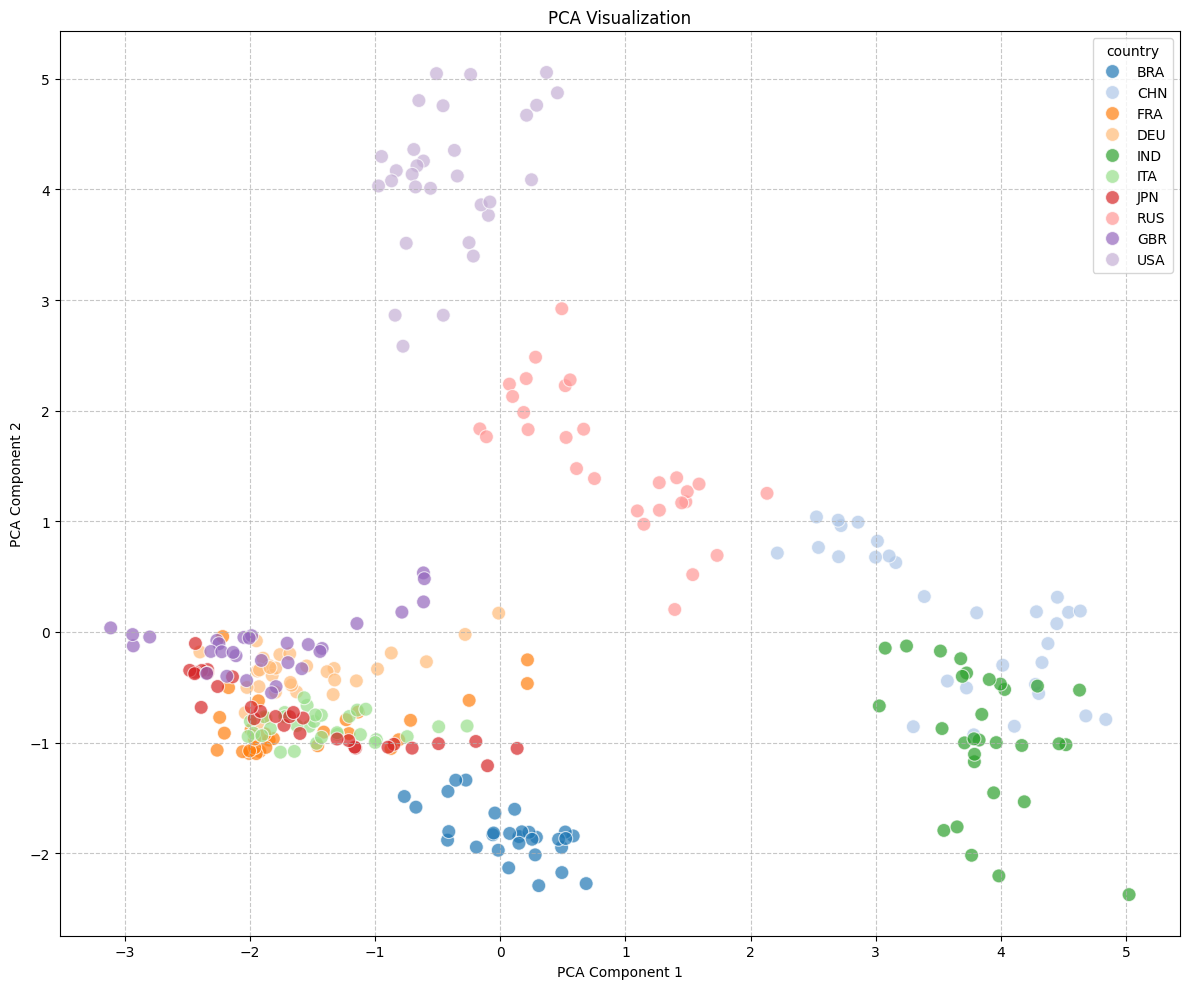

Explained variance ratio: [0.30505999 0.18434721]


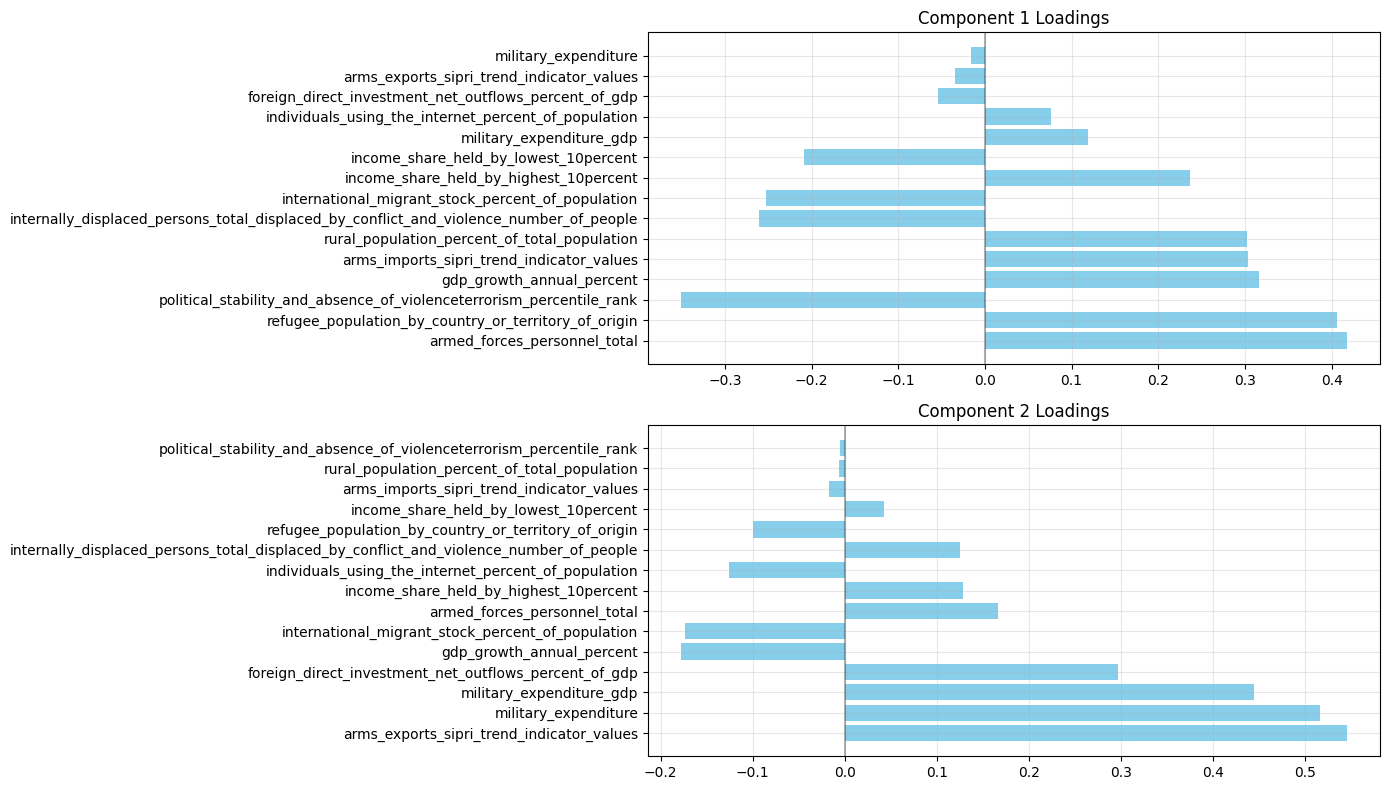

In [ ]:
# -------------------------------------------------------------------------
# Dimensionality Reduction and Visualization
# -------------------------------------------------------------------------

# Performs Principal Component Analysis to reduce data dimensions while preserving variance
def perform_pca(data_matrix, n_components=2):
    """
    Perform PCA dimensionality reduction
    
    Parameters:
    data_matrix (numpy.ndarray): Matrix of data for dimensionality reduction
    n_components (int): Number of components to reduce to (2 or 3 for visualization)
    
    Returns:
    tuple: (reduced_data, explained_variance_ratio, loadings)
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_matrix)
    
    # Initialize PCA with the specified number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA to the data and transform
    reduced_data = pca.fit_transform(scaled_data)
    
    # collect the loadings
    loadings = pca.components_

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    return reduced_data, explained_variance_ratio, loadings

# plot pca loadings
def plot_pca_loadings(components, feature_names, n_components=2):
    """
    Visualize the PCA loadings to understand which features contribute to each component
    
    Parameters:
    components (numpy.ndarray): PCA components/loadings
    feature_names (list): Names of features used in PCA
    n_components (int): Number of components to visualize (2 or 3)
    """
    # Limit to requested number of components
    components = components[:n_components]
    
    plt.figure(figsize=(14, n_components * 4))
    
    for i, component in enumerate(components):
        plt.subplot(n_components, 1, i + 1)
        # Sort loadings by absolute value for better visualization
        indices = np.argsort(np.abs(component))[::-1]
        
        plt.barh(range(len(indices)), component[indices], color='skyblue')
        plt.yticks(range(len(indices)), [feature_names[idx] for idx in indices])
        plt.title(f"Component {i+1} Loadings")
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
    
    plt.show()

def visualize_reduced_data(reduced_data, row_labels, title=None, technique='PCA', 
                         show_country_names=False, plot_3d=False, interactive=False):
    """
    Visualize the reduced data in a scatter plot with countries colored consistently
    
    Parameters:
    reduced_data (numpy.ndarray): The reduced data from a dimensionality reduction technique
    row_labels (list): Labels for each data point (ISO codes with year)
    title (str): Optional title for the plot
    technique (str): The technique used for dimensionality reduction (for the title)
    show_country_names (bool): Whether to show full country names instead of ISO codes
    plot_3d (bool): Whether to create a 3D plot (requires reduced_data to have 3 columns)
    interactive (bool): Whether to create an interactive plot using Plotly (works best with 3D)
    """
    # Check if we have enough components for 3D plotting
    if plot_3d and reduced_data.shape[1] < 3:
        print("Warning: 3D plot requested but data has fewer than 3 components. Falling back to 2D.")
        plot_3d = False
        
    if interactive and not plot_3d:
        print("Note: Interactive mode works best with 3D plots.")
    
    # Extract country codes from row labels (assuming format "ISO (year)")
    country_codes = [label.split(" (")[0] for label in row_labels]
    years = [label.split("(")[1].replace(")", "") for label in row_labels]
    
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        'x': reduced_data[:, 0],
        'y': reduced_data[:, 1],
        'country': country_codes,
        'year': years,
        'label': row_labels
    })
    
    if plot_3d:
        plot_df['z'] = reduced_data[:, 2]  # Add the third component
        
        if interactive:
            try:
                import plotly.express as px
                import plotly.graph_objects as go
                
                # If we need to convert ISO to country names
                if show_country_names and 'ISO_TO_NAME' in globals():
                    plot_df['country_name'] = [ISO_TO_NAME.get(code, code) for code in country_codes]
                    hover_data = {'country_name': True, 'year': True}
                    color_column = 'country_name'
                else:
                    hover_data = {'country': True, 'year': True}
                    color_column = 'country'
                
                # Create interactive 3D scatter plot
                fig = px.scatter_3d(
                    plot_df, 
                    x='x', 
                    y='y', 
                    z='z',
                    color=color_column,  # Color by country
                    hover_name='label',  # Show full label on hover
                    hover_data=hover_data,
                    title=title or f"Interactive {technique} 3D Visualization",
                    labels={
                        'x': f'{technique} Component 1',
                        'y': f'{technique} Component 2',
                        'z': f'{technique} Component 3'
                    },
                    opacity=0.7
                )
                
                # Improve appearance
                fig.update_traces(marker=dict(size=6))
                fig.update_layout(
                    legend_title_text='Countries',
                    scene=dict(
                        xaxis_title=f'{technique} Component 1',
                        yaxis_title=f'{technique} Component 2',
                        zaxis_title=f'{technique} Component 3',
                    )
                )
                
                # Show plot
                fig.show()
                return fig
                
            except ImportError:
                print("Warning: Plotly not installed. Falling back to static plot.")
                interactive = False
        
        if not interactive:  # Regular matplotlib 3D plot
            # Create 3D plot
            fig = plt.figure(figsize=(14, 12))
            ax = fig.add_subplot(111, projection='3d')
            
            # Get unique countries for consistent coloring
            unique_countries = list(set(country_codes))
            cmap = plt.cm.get_cmap('tab20' if len(unique_countries) <= 20 else 'rainbow')
            colors = {country: cmap(i/len(unique_countries)) for i, country in enumerate(unique_countries)}
            
            # Plot each country with its own color
            for country in unique_countries:
                country_data = plot_df[plot_df['country'] == country]
                ax.scatter(country_data['x'], country_data['y'], country_data['z'], 
                          label=country, 
                          alpha=0.7, 
                          s=80)
            
            # Add labels
            ax.set_xlabel(f"{technique} Component 1")
            ax.set_ylabel(f"{technique} Component 2")
            ax.set_zlabel(f"{technique} Component 3")
            
            # Use country names instead of ISO codes in the legend if requested
            if show_country_names and 'ISO_TO_NAME' in globals():
                handles, labels = ax.get_legend_handles_labels()
                new_labels = [ISO_TO_NAME.get(label, label) for label in labels]
                ax.legend(handles, new_labels)
            else:
                ax.legend()
            
            # Improve readability
            ax.grid(True)
            plt.title(title or f"{technique} Visualization")
            plt.tight_layout()
            plt.show()
            
    else:
        # Create 2D plot (original behavior)
        plt.figure(figsize=(12, 10))
        scatter_plot = sns.scatterplot(
            data=plot_df,
            x='x', 
            y='y',
            hue='country',
            palette='tab20',
            s=100,
            alpha=0.7
        )
        
        # Use country names instead of ISO codes in the legend if requested
        if show_country_names and 'ISO_TO_NAME' in globals():
            handles, labels = scatter_plot.get_legend_handles_labels()
            new_labels = [ISO_TO_NAME.get(label, label) for label in labels]
            plt.legend(handles, new_labels)
        
        plt.xlabel(f"{technique} Component 1")
        plt.ylabel(f"{technique} Component 2")
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.title(title or f"{technique} Visualization")
        plt.tight_layout()
        plt.show()

# test bed
pca, explained_variance_ratio , loadings= perform_pca(data_matrix, n_components=2)
print(pca.shape)

# Visualize the reduced data using PCA
visualize_reduced_data(pca, row_labels, title="PCA Visualization", technique='PCA', show_country_names=False)

# Visualize the PCA loadings and explained variance ratio to understand feature contributions
print("Explained variance ratio:", explained_variance_ratio)
plot_pca_loadings(components=loadings, feature_names=indicators, n_components=2)


(298, 3)
Explained variance ratio (3 components): [0.30505999 0.18434721 0.11422305]


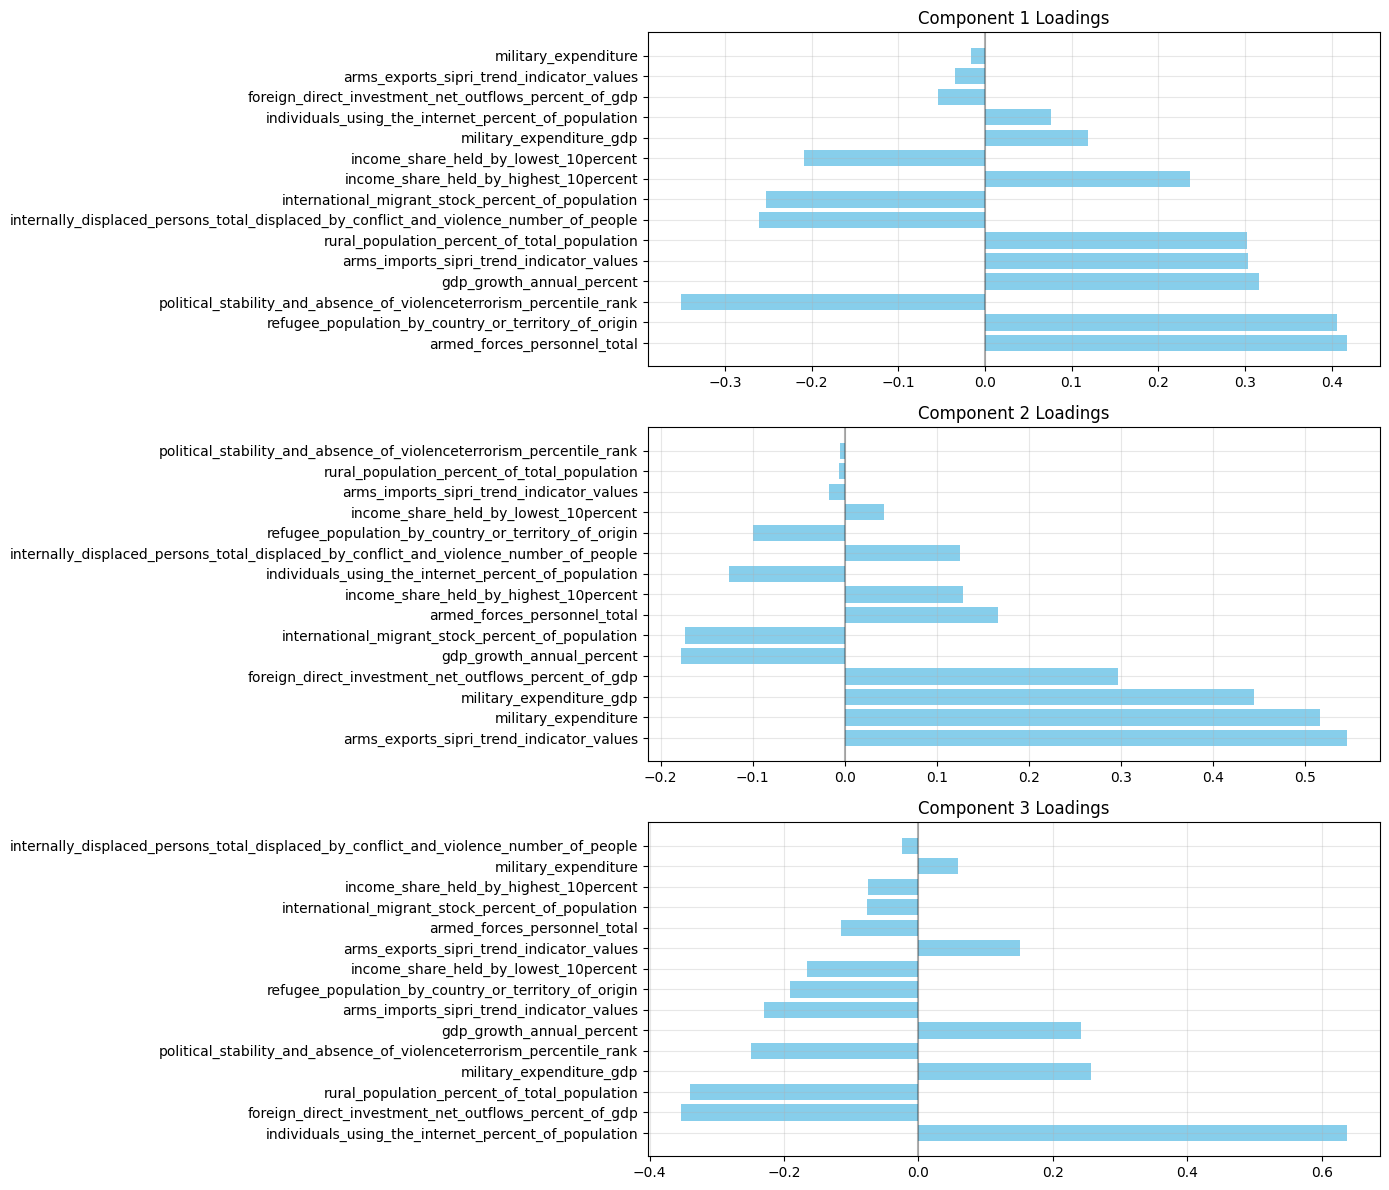

In [ ]:
# Run PCA with 3 components
pca_3d, explained_variance_ratio_3d, loadings_3d = perform_pca(data_matrix, n_components=3)
print(pca_3d.shape)
print("Explained variance ratio (3 components):", explained_variance_ratio_3d)

# Visualize in interactive 3D
visualize_reduced_data(pca_3d, row_labels, 
                      title="PCA 3D Visualization", 
                      technique='PCA', 
                      show_country_names=True,
                      plot_3d=True,
                      interactive=True)  # Set to True for interactive visualization

# Also show the loadings to understand feature contributions
plot_pca_loadings(components=loadings_3d, feature_names=indicators, n_components=3)

/Users/louisswanepoel/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



(298, 2)


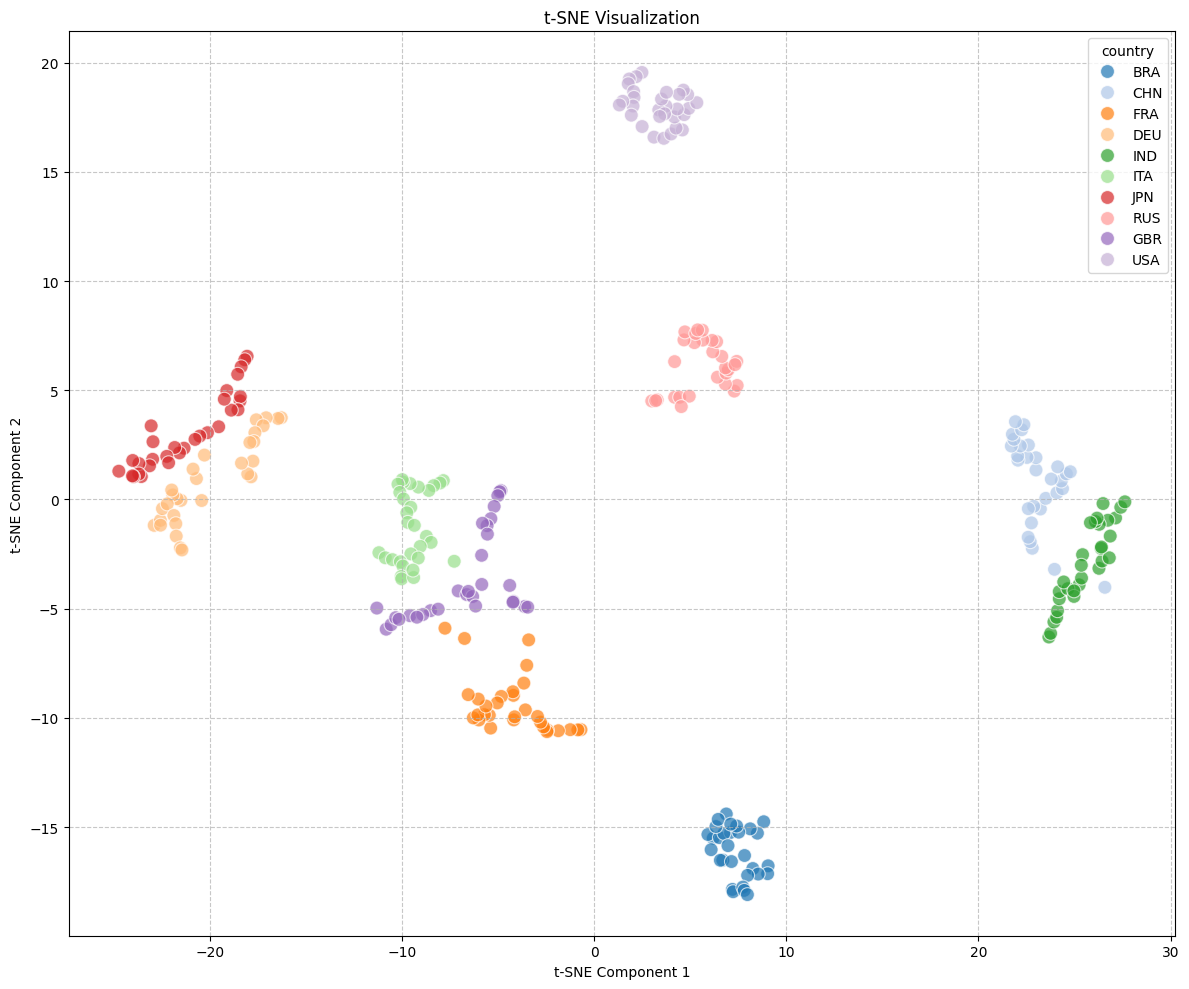

In [ ]:
# Performs t-SNE dimensionality reduction for non-linear data visualization
def perform_tsne(data_matrix, n_components=2, perplexity=30, n_iter=1000, random_state=42):
    """
    Perform t-SNE dimensionality reduction
    
    Parameters:
    data_matrix (numpy.ndarray): Matrix of data for dimensionality reduction
    n_components (int): Number of components to reduce to
    perplexity (float): The perplexity parameter for t-SNE
    n_iter (int): Number of iterations for optimization
    random_state (int): Random seed for reproducibility
    
    Returns:
    numpy.ndarray: Reduced data
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_matrix)
    
    # Initialize t-SNE with the specified parameters
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        n_iter=n_iter,
        random_state=random_state
    )
    
    # Fit t-SNE to the data and transform
    reduced_data = tsne.fit_transform(scaled_data)
    
    return reduced_data

# test bed
# Run t-SNE with 2 components
tsne = perform_tsne(data_matrix, n_components=2)
print(tsne.shape)
visualize_reduced_data(tsne, row_labels, title="t-SNE Visualization", technique='t-SNE', show_country_names=False)